In [2]:
# test azure
import sys, time, json
# from openai import OpenAI
import pandas as pd
import re
from glob import glob

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

### Workbook for extracting results from API-geneLLM

1. Define main question key: This is a dictionary you will see in next code block <mainkey_question_key> that has unique element from each line of question (or scoring statement) from your input parameter  file.

2. The code will use the output JSON file from API driven mode to extract scores for each question and make a csv file.


In [3]:

# define key dictionary for each question for concrete formatting

mainkey_qestion_key = {'summary':'Summary',
               'type I interferon':'Ifn_type1',
                'type II interferon':'Ifn_type2',
                'type III interferon':'Ifn_type3',
                'circulating leukocytes immune biology':'leu_imm__biol',
                'biomarker in clinical settings':'biomarker_clinical',
                'blood transcriptional biomarker':'pot_bolldtransc_biomarker',
                'known drug target':'drug_target',
                'therapeutically relevant':'theraputically_rel',
               }


def find_keyword(sline, keyLib):
    for mk in keyLib.keys():

        # Regular expression pattern to find all combinations of the letters in 'gene'
        pattern = r'{}'.format(mk)

        # Finding all matches in the sample text
        matches = re.findall(pattern, sline, re.IGNORECASE)
        if matches:
            return keyLib[mk]
        else:
            next
    return False



def convert_stringtodict(lines, keylib):
    dict_line = {}
    for k in lines:
        ksplit = k.split(":")

        if len(ksplit) ==2:
            key_tmp = find_keyword(ksplit[0].strip("\'|\"|', |").strip(), keylib)
            val_tmp = ksplit[1].strip("\'|\"|',|{|} ").strip()
            if key_tmp and val_tmp:
                if key_tmp == "Summary":
                    dict_line[key_tmp] = val_tmp
                else:
                    try:
                        dict_line[key_tmp] = float(val_tmp)
                    except:
                        dict_line[key_tmp] = 0
            else:
                next
                # print ("error in ", ksplit)

    return dict_line

def get_qScore(q, question_dict, subkey):
    q_scores = []
    for gname in q.keys():
        for model in q[gname].keys():
            kx = convert_stringtodict(q[gname][model],question_dict)
            kx.update({'gene_name':gname,
                        'runID':model,
                        "model_version":model.lstrip("datasvc-openai-compsci-poc-").split("_")[0],
                        "subjectKey":subkey,})
            q_scores.append(kx)
    print (len(q_scores))
    return pd.DataFrame(q_scores)

In [ ]:
def getScores(dfX):
    _scores = dfX.set_index("gene_name").unstack().reset_index()
    _scores = _scores.rename({"level_0":'prompt',0:'response_score'},axis=1)
    score_aggregate = _scores.groupby(['gene_name','prompt'])['response_score'].agg(['mean','std'])
    return score_aggregate.reset_index()

def get_plot(df, moduleName):
    score_aggregatePT_mean = df.pivot_table(index="gene_name",columns="prompt",values="mean")
    genesorted_Score = list(score_aggregatePT_mean.sum(axis=1).sort_values().index)

    barplot_Scores = alt.Chart(df).mark_bar().encode(
        y=alt.Y('gene_name',sort=genesorted_Score),
        x='sum(mean)',
        color='prompt'
    ).properties(title="{} scores".format(moduleName))

    scoreDetailPlot =alt.Chart(df).mark_point(filled=True).encode(
        x= alt.X("prompt"),
        y= alt.Y("gene_name",sort=genesorted_Score),
        color=alt.Color("mean", scale=alt.Scale(scheme="lightgreyred",reverse=False)),
        size=alt.Size("std",scale=alt.Scale(reverse=True)),
        tooltip=['mean','std','gene_name','prompt']
    ).properties(title="{} Mean scores : STD".format(moduleName))

    scoresX = barplot_Scores|scoreDetailPlot

    return scoresX

In [6]:
ifn_outdir = "../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/*.json"
fileList = glob(ifn_outdir)
print ("\n".join(fileList))

../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M8.3_response1_g4.json
../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M10.1_response1_g4.json
../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M15.127_response1_g4.json
../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M13.17_response1_g4.json
../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M15.64_response1_g4.json
../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M10.1_response1_g4_5run.json
../../../../g4API_app/bloodgen3Gensets/Interferone/outResult_g4t/M15.86_response1_g4.json


In [17]:
responseDF = pd.DataFrame()
for k in fileList:
    glist_name = k.split("/")[-1].split("_")[0]
    # print (glist_name, k.split("/")[-1].split("_")[-1][:3])
    if  k.split("/")[-1].split("_")[-1][:4] == "5run":
        runKey = glist_name+"_5x"
        print (runKey)
    else:
        runKey = glist_name+"_3x"
    mod_Resp = json.load(open(k,"r"))
    csv_mod_Resp = get_qScore(mod_Resp,mainkey_qestion_key, subkey=runKey)
    csv_mod_Resp['moduleID'] = glist_name
    print (runKey, csv_mod_Resp.shape[0])
    responseDF  =pd.concat([responseDF,csv_mod_Resp],axis=0).reset_index().drop('index',axis=1)


51
M8.3_3x 51
63
M10.1_3x 63
33
M15.127_3x 33
93
M13.17_3x 93
63
M15.64_3x 63
M10.1_5x
105
M10.1_5x 105
39
M15.86_3x 39


In [18]:
responseDF.groupby("subjectKey").size()

subjectKey
M10.1_3x       63
M10.1_5x      105
M13.17_3x      93
M15.127_3x     33
M15.64_3x      63
M15.86_3x      39
M8.3_3x        51
dtype: int64

In [23]:
score_cols = ['gene_name','Ifn_type1', 'Ifn_type2', 'Ifn_type3', 'leu_imm__biol',
       'biomarker_clinical', 'pot_bolldtransc_biomarker', 'drug_target',
       'theraputically_rel','subjectKey', 'moduleID']

responseDF.columns

Index(['Summary', 'Ifn_type1', 'Ifn_type2', 'Ifn_type3', 'leu_imm__biol',
       'biomarker_clinical', 'pot_bolldtransc_biomarker', 'drug_target',
       'theraputically_rel', 'gene_name', 'runID', 'model_version',
       'subjectKey', 'moduleID'],
      dtype='object')

In [24]:
responseDF[score_cols]

,gene_name,Ifn_type1,Ifn_type2,Ifn_type3,leu_imm__biol,biomarker_clinical,pot_bolldtransc_biomarker,drug_target,theraputically_rel,subjectKey,moduleID
0,EPSTI1,7.0,3.0,2.0,6.0,4.0,5.0,1.0,5.0,M8.3_3x,M8.3
1,EPSTI1,7.0,3.0,3.0,6.0,2.0,5.0,1.0,4.0,M8.3_3x,M8.3
2,EPSTI1,7.0,4.0,3.0,6.0,3.0,5.0,1.0,5.0,M8.3_3x,M8.3
3,HERC5,9.0,4.0,3.0,7.0,2.0,6.0,1.0,5.0,M8.3_3x,M8.3
4,HERC5,9.0,4.0,3.0,8.0,2.0,5.0,1.0,7.0,M8.3_3x,M8.3
...,...,...,...,...,...,...,...,...,...,...,...
442,TIMM10,2.0,2.0,2.0,4.0,1.0,3.0,0.0,2.0,M15.86_3x,M15.86
443,TIMM10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,M15.86_3x,M15.86
444,UBE2L6,8.0,5.0,3.0,7.0,2.0,6.0,1.0,4.0,M15.86_3x,M15.86
445,UBE2L6,7.0,5.0,3.0,8.0,2.0,6.0,1.0,5.0,M15.86_3x,M15.86


### Bench-marking on M10.1

In [70]:
col_names_Redo = {'Ifn_type1':'a. Association with type I interferon responses',\
'Ifn_type2':'b. Association with type II interferon responses',\
'Ifn_type3':'c. Association with type III interferon responses',\
'leu_imm__biol':'d. Relevant to circulating leukocytes immune biology',\
'biomarker_clinical':'e. Used as a biomarker in clinical settings',\
'pot_bolldtransc_biomarker':'f. Potential value as a blood transcriptional biomarker',\
'drug_target':'g. Known drug target',\
'theraputically_rel':'h. Therapeutically relevant for immune system diseases'}

In [71]:
manual_scores = pd.read_csv("../data_repo/CaseStudy/Interferone/ManualScores_10.1.csv").dropna()
manual_scores

,GeneSymbol,Statements,GPT-4 M US,GPT-4 M Thai,Claude-3,GPT-4 Qatar
0,DDX58,a. Association with type I interferon responses,10.000000,10.000000,10.0,9.000000
1,DDX58,b. Association with type II interferon responses,5.666667,4.333333,4.0,3.333333
2,DDX58,c. Association with type III interferon responses,7.333333,7.666667,7.0,5.333333
3,DDX58,d. Relevance to circulating leukocytes immune ...,8.666667,6.000000,8.0,6.000000
4,DDX58,e. Used as a biomarker in clinical settings,6.000000,2.333333,3.0,2.000000
...,...,...,...,...,...,...
163,ZBP1,d. Relevance to circulating leukocytes immune ...,8.333333,8.000000,8.0,7.333333
164,ZBP1,e. Used as a biomarker in clinical settings,6.333333,5.666667,4.0,2.666667
165,ZBP1,f. Potential value as a blood transcriptional ...,7.333333,6.666667,7.0,5.000000
166,ZBP1,g. Known drug target,5.333333,5.000000,3.0,3.333333


In [72]:
api_benchmark = responseDF[responseDF.moduleID=="M10.1"]

In [73]:
api_benchmark = api_benchmark[score_cols].reset_index().drop('index',axis=1)
api_benchmark['gene_key'] = api_benchmark['gene_name']+"_" + api_benchmark['subjectKey']
api_benchmark_melt = api_benchmark.melt(id_vars='gene_key',value_vars=['Ifn_type1', 'Ifn_type2', 'Ifn_type3', 'leu_imm__biol',
       'biomarker_clinical', 'pot_bolldtransc_biomarker', 'drug_target',
       'theraputically_rel',],value_name='score',var_name='statement')

api_benchmark_melt_agg = api_benchmark_melt.groupby(['gene_key','statement'])['score'].mean().reset_index()
api_benchmark_melt_agg.head()


,gene_key,statement,score
0,DDX58_M10.1_3x,Ifn_type1,10.000000
1,DDX58_M10.1_3x,Ifn_type2,3.666667
2,DDX58_M10.1_3x,Ifn_type3,5.666667
3,DDX58_M10.1_3x,biomarker_clinical,1.666667
4,DDX58_M10.1_3x,drug_target,3.333333


In [74]:
api_benchmark_melt_agg['statement_detail'] = api_benchmark_melt_agg['statement'].map(col_names_Redo)
api_benchmark_melt_agg.head()

,gene_key,statement,score,statement_detail
0,DDX58_M10.1_3x,Ifn_type1,10.000000,a. Association with type I interferon responses
1,DDX58_M10.1_3x,Ifn_type2,3.666667,b. Association with type II interferon responses
2,DDX58_M10.1_3x,Ifn_type3,5.666667,c. Association with type III interferon responses
3,DDX58_M10.1_3x,biomarker_clinical,1.666667,e. Used as a biomarker in clinical settings
4,DDX58_M10.1_3x,drug_target,3.333333,g. Known drug target


In [75]:
api_benchmark_melt_agg['geneSymbol'] = [i.split("_")[0] for i in api_benchmark_melt_agg.gene_key]
api_benchmark_melt_agg['api_run'] = [i.split("_")[-1] for i in api_benchmark_melt_agg.gene_key]
api_benchmark_melt_agg['moduleID'] = [i.split("_")[1] for i in api_benchmark_melt_agg.gene_key]
api_benchmark_melt_agg.head()

,gene_key,statement,score,statement_detail,geneSymbol,api_run,moduleID
0,DDX58_M10.1_3x,Ifn_type1,10.000000,a. Association with type I interferon responses,DDX58,3x,M10.1
1,DDX58_M10.1_3x,Ifn_type2,3.666667,b. Association with type II interferon responses,DDX58,3x,M10.1
2,DDX58_M10.1_3x,Ifn_type3,5.666667,c. Association with type III interferon responses,DDX58,3x,M10.1
3,DDX58_M10.1_3x,biomarker_clinical,1.666667,e. Used as a biomarker in clinical settings,DDX58,3x,M10.1
4,DDX58_M10.1_3x,drug_target,3.333333,g. Known drug target,DDX58,3x,M10.1


In [76]:
api_run_agg = api_benchmark_melt_agg.pivot(index=["statement_detail",'geneSymbol'], columns='api_run',values='score').reset_index()

In [77]:
manual_scores['keyX'] = manual_scores['GeneSymbol']+"_"+manual_scores['Statements']
manual_scores = manual_scores.set_index("keyX")
manual_scores.head()

,GeneSymbol,Statements,GPT-4 M US,GPT-4 M Thai,Claude-3,GPT-4 Qatar
keyX,,,,,,
DDX58_a. Association with type I interferon responses,DDX58,a. Association with type I interferon responses,10.000000,10.000000,10.0,9.000000
DDX58_b. Association with type II interferon responses,DDX58,b. Association with type II interferon responses,5.666667,4.333333,4.0,3.333333
DDX58_c. Association with type III interferon responses,DDX58,c. Association with type III interferon responses,7.333333,7.666667,7.0,5.333333
DDX58_d. Relevance to circulating leukocytes immune biology,DDX58,d. Relevance to circulating leukocytes immune ...,8.666667,6.000000,8.0,6.000000
DDX58_e. Used as a biomarker in clinical settings,DDX58,e. Used as a biomarker in clinical settings,6.000000,2.333333,3.0,2.000000


In [78]:
manual_scores['Statements'].unique()

array(['a. Association with type I interferon responses',
       'b. Association with type II interferon responses',
       'c. Association with type III interferon responses',
       'd. Relevance to circulating leukocytes immune biology',
       'e. Used as a biomarker in clinical settings',
       'f. Potential value as a blood transcriptional biomarker',
       'g. Known drug target',
       'h. Therapeutically relevant for immune system diseases'],
      dtype=object)

In [137]:
manual_scores = manual_scores.sort_values(by=['GeneSymbol','Statements']).reset_index()

In [138]:
api_run_agg['keyX'] = api_run_agg['geneSymbol']+"_"+api_run_agg['statement_detail']
api_run_agg = api_run_agg.set_index("keyX")
api_run_agg = api_run_agg.sort_values(by=['geneSymbol','statement_detail']).reset_index()

In [80]:
api_run_agg.statement_detail.unique()

array(['a. Association with type I interferon responses',
       'b. Association with type II interferon responses',
       'c. Association with type III interferon responses',
       'd. Relevant to circulating leukocytes immune biology',
       'e. Used as a biomarker in clinical settings',
       'f. Potential value as a blood transcriptional biomarker',
       'g. Known drug target',
       'h. Therapeutically relevant for immune system diseases'],
      dtype=object)

In [139]:
pd.concat([api_run_agg,manual_scores],axis=1)

,keyX,statement_detail,geneSymbol,3x,5x,keyX,GeneSymbol,Statements,GPT-4 M US,GPT-4 M Thai,Claude-3,GPT-4 Qatar
0,DDX58_a. Association with type I interferon re...,a. Association with type I interferon responses,DDX58,10.000000,10.0,DDX58_a. Association with type I interferon re...,DDX58,a. Association with type I interferon responses,10.000000,10.000000,10.0,9.000000
1,DDX58_b. Association with type II interferon r...,b. Association with type II interferon responses,DDX58,3.666667,5.8,DDX58_b. Association with type II interferon r...,DDX58,b. Association with type II interferon responses,5.666667,4.333333,4.0,3.333333
2,DDX58_c. Association with type III interferon ...,c. Association with type III interferon responses,DDX58,5.666667,6.2,DDX58_c. Association with type III interferon ...,DDX58,c. Association with type III interferon responses,7.333333,7.666667,7.0,5.333333
3,DDX58_d. Relevant to circulating leukocytes im...,d. Relevant to circulating leukocytes immune b...,DDX58,8.666667,8.4,DDX58_d. Relevance to circulating leukocytes i...,DDX58,d. Relevance to circulating leukocytes immune ...,8.666667,6.000000,8.0,6.000000
4,DDX58_e. Used as a biomarker in clinical settings,e. Used as a biomarker in clinical settings,DDX58,1.666667,3.0,DDX58_e. Used as a biomarker in clinical settings,DDX58,e. Used as a biomarker in clinical settings,6.000000,2.333333,3.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
163,ZBP1_d. Relevant to circulating leukocytes imm...,d. Relevant to circulating leukocytes immune b...,ZBP1,8.000000,7.8,ZBP1_d. Relevance to circulating leukocytes im...,ZBP1,d. Relevance to circulating leukocytes immune ...,8.333333,8.000000,8.0,7.333333
164,ZBP1_e. Used as a biomarker in clinical settings,e. Used as a biomarker in clinical settings,ZBP1,2.333333,2.4,ZBP1_e. Used as a biomarker in clinical settings,ZBP1,e. Used as a biomarker in clinical settings,6.333333,5.666667,4.0,2.666667
165,ZBP1_f. Potential value as a blood transcripti...,f. Potential value as a blood transcriptional ...,ZBP1,5.666667,5.8,ZBP1_f. Potential value as a blood transcripti...,ZBP1,f. Potential value as a blood transcriptional ...,7.333333,6.666667,7.0,5.000000
166,ZBP1_g. Known drug target,g. Known drug target,ZBP1,1.666667,2.2,ZBP1_g. Known drug target,ZBP1,g. Known drug target,5.333333,5.000000,3.0,3.333333


In [140]:
benchmarking_m10_1 = pd.concat([api_run_agg,manual_scores],axis=1)
benchmarking_m10_1 = benchmarking_m10_1.reset_index().drop(['keyX','statement_detail','geneSymbol'],axis=1)
benchmarking_m10_1 = benchmarking_m10_1[['GeneSymbol','Statements','3x','5x','GPT-4 M US','GPT-4 M Thai','GPT-4 Qatar','Claude-3']]
benchmarking_m10_1.shape

(168, 8)

In [141]:
benchmarking_m10_1.dropna()

,GeneSymbol,Statements,3x,5x,GPT-4 M US,GPT-4 M Thai,GPT-4 Qatar,Claude-3
0,DDX58,a. Association with type I interferon responses,10.000000,10.0,10.000000,10.000000,9.000000,10.0
1,DDX58,b. Association with type II interferon responses,3.666667,5.8,5.666667,4.333333,3.333333,4.0
2,DDX58,c. Association with type III interferon responses,5.666667,6.2,7.333333,7.666667,5.333333,7.0
3,DDX58,d. Relevance to circulating leukocytes immune ...,8.666667,8.4,8.666667,6.000000,6.000000,8.0
4,DDX58,e. Used as a biomarker in clinical settings,1.666667,3.0,6.000000,2.333333,2.000000,3.0
...,...,...,...,...,...,...,...,...
163,ZBP1,d. Relevance to circulating leukocytes immune ...,8.000000,7.8,8.333333,8.000000,7.333333,8.0
164,ZBP1,e. Used as a biomarker in clinical settings,2.333333,2.4,6.333333,5.666667,2.666667,4.0
165,ZBP1,f. Potential value as a blood transcriptional ...,5.666667,5.8,7.333333,6.666667,5.000000,7.0
166,ZBP1,g. Known drug target,1.666667,2.2,5.333333,5.000000,3.333333,3.0


In [277]:
benchmarking_m10_1.sort_values(by=['GeneSymbol','Statements']).to_csv("../data_repo/CaseStudy/Interferone/Benchmarking_M10.1.csv.gz",compression="gzip")

In [116]:
!pip3 install scipy

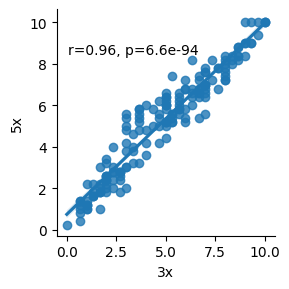

In [143]:
import scipy as sp

g = sns.lmplot(x='3x', y='5x', data=benchmarking_m10_1, height=3, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['3x'], data['5x'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

In [144]:
benchmarking_m10_1.columns

Index(['GeneSymbol', 'Statements', '3x', '5x', 'GPT-4 M US', 'GPT-4 M Thai',
       'GPT-4 Qatar', 'Claude-3'],
      dtype='object')

In [145]:
benchmarking_m10_1 = benchmarking_m10_1.rename({'3x':'API_3x','5x':'API_5x','GPT-4 M US':'Manual_US', 'GPT-4 M Thai':'Manual_Thailand',
       'GPT-4 Qatar':'Manual_Qatar'},axis=1)
benchmarking_m10_1.head()

,GeneSymbol,Statements,API_3x,API_5x,Manual_US,Manual_Thailand,Manual_Qatar,Claude-3
0,DDX58,a. Association with type I interferon responses,10.000000,10.0,10.000000,10.000000,9.000000,10.0
1,DDX58,b. Association with type II interferon responses,3.666667,5.8,5.666667,4.333333,3.333333,4.0
2,DDX58,c. Association with type III interferon responses,5.666667,6.2,7.333333,7.666667,5.333333,7.0
3,DDX58,d. Relevance to circulating leukocytes immune ...,8.666667,8.4,8.666667,6.000000,6.000000,8.0
4,DDX58,e. Used as a biomarker in clinical settings,1.666667,3.0,6.000000,2.333333,2.000000,3.0


In [284]:
corr_inter = benchmarking_m10_1[['API_3x', 'API_5x', 'Manual_US',
       'Manual_Thailand', 'Manual_Qatar', 'Claude-3']].corr()
corr_inter

,API_3x,API_5x,Manual_US,Manual_Thailand,Manual_Qatar,Claude-3
API_3x,1.000000,0.960246,0.817144,0.790957,0.920438,0.895893
API_5x,0.960246,1.000000,0.843101,0.807011,0.930372,0.893854
Manual_US,0.817144,0.843101,1.000000,0.919560,0.888353,0.843684
Manual_Thailand,0.790957,0.807011,0.919560,1.000000,0.874960,0.850782
Manual_Qatar,0.920438,0.930372,0.888353,0.874960,1.000000,0.877149
Claude-3,0.895893,0.893854,0.843684,0.850782,0.877149,1.000000


In [285]:
corr_interX = corr_inter.unstack().reset_index().rename({'level_0':'callMode1','level_1':'callMode2',0:'pearsonCorr'},axis=1)

alt.Chart(corr_interX).mark_rect().encode(
    x=alt.X("callMode1"),
    y=alt.Y("callMode2"),
    color=alt.Color('pearsonCorr',scale=alt.Scale(scheme="tealblues")),
    tooltip=['pearsonCorr']

)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [147]:

    
def get_lmplot(df,x,y,height=3, aspect=1):
    g = sns.lmplot(x=x, y=y, data=df, height=height, aspect=aspect)

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data[x], data[y])
        ax = plt.gca()
        ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)
        r, p = sp.stats.pearsonr(data[x], data[y])
    return g.map_dataframe(annotate)

In [316]:
def pearsoncorr(kgrp):
    col1=kgrp.values[:,1]
    col2 = kgrp.values[:,2]
    r, p = sp.stats.pearsonr(col1,col2)
    return pd.Series((r,p),index=['r','p'])

benchmarking_m10_1[['Statements','API_3x','API_5x']].groupby('Statements').apply(pearsoncorr)

,r,p
Statements,,
a. Association with type I interferon responses,0.983368,1.540991e-15
b. Association with type II interferon responses,0.945406,1.064851e-10
c. Association with type III interferon responses,0.932734,7.357845e-10
d. Relevance to circulating leukocytes immune biology,0.966150,1.231762e-12
e. Used as a biomarker in clinical settings,0.870620,2.865778e-07
f. Potential value as a blood transcriptional biomarker,0.843746,1.542308e-06
g. Known drug target,0.971004,2.884758e-13
h. Therapeutically relevant for immune system diseases,0.970772,3.108961e-13


In [309]:
for kname, kgrp in benchmarking_m10_1[['Statements','API_3x','API_5x']].groupby('Statements'):
    col1 = kgrp.values[:,1]
    col2 = kgrp.values[:,2]
    print (kname, sp.stats.pearsonr(col1,col2))


a. Association with type I interferon responses PearsonRResult(statistic=0.9833677413783755, pvalue=1.5409910153291487e-15)
b. Association with type II interferon responses PearsonRResult(statistic=0.9454058849943904, pvalue=1.0648506714039046e-10)
c. Association with type III interferon responses PearsonRResult(statistic=0.9327338914008259, pvalue=7.357845442080082e-10)
d. Relevance to circulating leukocytes immune biology PearsonRResult(statistic=0.9661498521925312, pvalue=1.2317619334110113e-12)
e. Used as a biomarker in clinical settings PearsonRResult(statistic=0.8706196636893215, pvalue=2.8657777363631464e-07)
f. Potential value as a blood transcriptional biomarker PearsonRResult(statistic=0.8437456441952464, pvalue=1.5423084515366692e-06)
g. Known drug target PearsonRResult(statistic=0.9710041326194996, pvalue=2.884758301699881e-13)
h. Therapeutically relevant for immune system diseases PearsonRResult(statistic=0.9707720015038386, pvalue=3.108960501930983e-13)


In [320]:
import itertools

mode_pair = list(itertools.combinations(['API_3x', 'API_5x', 'Manual_US',
       'Manual_Thailand', 'Manual_Qatar', 'Claude-3'],2))
mode_pair

[('API_3x', 'API_5x'),
 ('API_3x', 'Manual_US'),
 ('API_3x', 'Manual_Thailand'),
 ('API_3x', 'Manual_Qatar'),
 ('API_3x', 'Claude-3'),
 ('API_5x', 'Manual_US'),
 ('API_5x', 'Manual_Thailand'),
 ('API_5x', 'Manual_Qatar'),
 ('API_5x', 'Claude-3'),
 ('Manual_US', 'Manual_Thailand'),
 ('Manual_US', 'Manual_Qatar'),
 ('Manual_US', 'Claude-3'),
 ('Manual_Thailand', 'Manual_Qatar'),
 ('Manual_Thailand', 'Claude-3'),
 ('Manual_Qatar', 'Claude-3')]

In [334]:
statement_rel = pd.DataFrame(index=benchmarking_m10_1.Statements.unique())
for kname, kgrp in benchmarking_m10_1.groupby("Statements"):
    for kpair in mode_pair:
        kapr_name = ":".join(kpair)
        col1 = kgrp[kpair[0]].values
        col2 = kgrp[kpair[1]].values
        r, p = sp.stats.pearsonr(col1,col2)
        statement_rel.loc[kname,kapr_name+"_r"] = round(r,2)
        # statement_rel.loc[kname, kapr_name+"_p"] = p


In [341]:
import scipy.stats as sT

In [357]:
statement_rel_zscore = statement_rel.apply(sT.zscore,axis=0)

In [361]:
statement_relPT = statement_rel.unstack().reset_index().rename({'level_0':'modePair','level_1':'statements',0:'pearson_r'},axis=1)

alt.Chart(statement_relPT,width=500, height=200).mark_rect().encode(
        x=alt.X("modePair",axis=alt.Axis(labelFontSize=14,labelLimit=500,title='')),
        y=alt.Y("statements",axis=alt.Axis(labelFontSize=14,labelLimit=500,title='')),
        color=alt.Color('pearson_r',scale=alt.Scale(scheme='blueorange',clamp=True)),
        tooltip=['modePair','statements','pearson_r']
    )

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

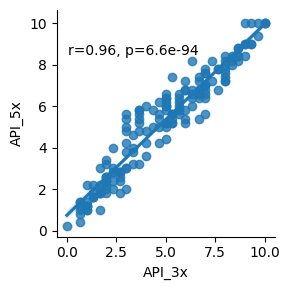

In [148]:
get_lmplot(benchmarking_m10_1,'API_3x','API_5x')

In [368]:
benchmarking_m10_1.head()

,GeneSymbol,Statements,API_3x,API_5x,Manual_US,Manual_Thailand,Manual_Qatar,Claude-3
0,DDX58,a. Association with type I interferon responses,10.000000,10.0,10.000000,10.000000,9.000000,10.0
1,DDX58,b. Association with type II interferon responses,3.666667,5.8,5.666667,4.333333,3.333333,4.0
2,DDX58,c. Association with type III interferon responses,5.666667,6.2,7.333333,7.666667,5.333333,7.0
3,DDX58,d. Relevance to circulating leukocytes immune ...,8.666667,8.4,8.666667,6.000000,6.000000,8.0
4,DDX58,e. Used as a biomarker in clinical settings,1.666667,3.0,6.000000,2.333333,2.000000,3.0


In [370]:
alt.Chart(benchmarking_m10_1).mark_point(filled=True).encode(
    x=alt.X("API_3x"),
    y=alt.Y("API_5x"),
    color=alt.Color("Statements"),
    tooltip=['GeneSymbol','Statements']
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

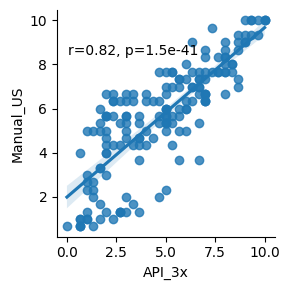

In [149]:
get_lmplot(benchmarking_m10_1,'API_3x','Manual_US')

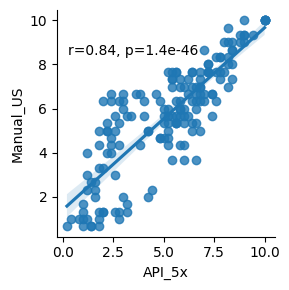

In [150]:
get_lmplot(benchmarking_m10_1,'API_5x','Manual_US')

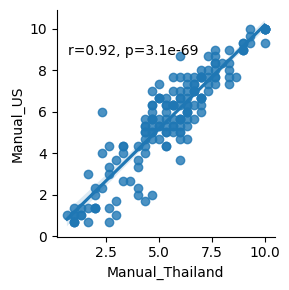

In [152]:
get_lmplot(benchmarking_m10_1,'Manual_Thailand','Manual_US')

In [155]:
score_cols = ['API_3x', 'API_5x', 'Manual_US',
       'Manual_Thailand', 'Manual_Qatar', 'Claude-3']

benchmarking_m10_1_statement = benchmarking_m10_1.groupby(['Statements'])[score_cols].apply('corr')

In [159]:
benchmarking_m10_1_statement = benchmarking_m10_1_statement.reset_index()
benchmarking_m10_1_statement['s_label'] = benchmarking_m10_1_statement.Statements+"_"+benchmarking_m10_1_statement.level_1

In [162]:
benchmarking_m10_1_statement['median_corr'] = benchmarking_m10_1_statement[score_cols].median(axis=1)
benchmarking_m10_1_statement['std_corr'] = benchmarking_m10_1_statement[score_cols].std(axis=1)

In [165]:
bench_agg = benchmarking_m10_1_statement[['Statements','level_1','median_corr','std_corr']]
bench_agg

,Statements,level_1,median_corr,std_corr
0,a. Association with type I interferon responses,API_3x,0.964617,0.035164
1,a. Association with type I interferon responses,API_5x,0.959494,0.038248
2,a. Association with type I interferon responses,Manual_US,0.968020,0.056361
3,a. Association with type I interferon responses,Manual_Thailand,0.951486,0.046844
4,a. Association with type I interferon responses,Manual_Qatar,0.966244,0.066134
5,a. Association with type I interferon responses,Claude-3,0.874981,0.064219
6,b. Association with type II interferon responses,API_3x,0.924450,0.068516
7,b. Association with type II interferon responses,API_5x,0.939560,0.080660
8,b. Association with type II interferon responses,Manual_US,0.943844,0.071698
9,b. Association with type II interferon responses,Manual_Thailand,0.909193,0.042910


In [169]:
alt.Chart(bench_agg).mark_point(filled=True).encode(
    y=alt.Y('Statements'),
    x=alt.X('level_1'),
    color=alt.Color('median_corr'),
    size=alt.Size('std_corr')

)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Plot aggregate score for each module and select top candidate

In [203]:
experiment_mode = '3x'
score_col_abb = ['Ifn_type1', 'Ifn_type2', 'Ifn_type3', 'leu_imm__biol',
       'biomarker_clinical', 'pot_bolldtransc_biomarker', 'drug_target',
       'theraputically_rel']
dx = responseDF[responseDF.subjectKey.str.endswith("3x")].reset_index().drop('index',axis=1)

In [204]:
dx['gene_module'] = dx.gene_name+"_"+dx.moduleID
dx = dx.set_index("gene_module")
dx_metadata = dx[['gene_name','Summary','model_version']]
dx_num = dx[score_col_abb]


In [205]:
dx_num

,Ifn_type1,Ifn_type2,Ifn_type3,leu_imm__biol,biomarker_clinical,pot_bolldtransc_biomarker,drug_target,theraputically_rel
gene_module,,,,,,,,
EPSTI1_M8.3,7.0,3.0,2.0,6.0,4.0,5.0,1.0,5.0
EPSTI1_M8.3,7.0,3.0,3.0,6.0,2.0,5.0,1.0,4.0
EPSTI1_M8.3,7.0,4.0,3.0,6.0,3.0,5.0,1.0,5.0
HERC5_M8.3,9.0,4.0,3.0,7.0,2.0,6.0,1.0,5.0
HERC5_M8.3,9.0,4.0,3.0,8.0,2.0,5.0,1.0,7.0
...,...,...,...,...,...,...,...,...
TIMM10_M15.86,2.0,2.0,2.0,4.0,1.0,3.0,0.0,2.0
TIMM10_M15.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UBE2L6_M15.86,8.0,5.0,3.0,7.0,2.0,6.0,1.0,4.0


In [206]:
dx_melt = dx.reset_index().melt(id_vars='gene_module',value_vars=score_col_abb,var_name='statement',value_name='score')

dx_melt_agg =dx_melt.groupby(['gene_module','statement'])['score'].agg('mean').reset_index()

In [266]:
def get_plot(df, moduleName):
    score_aggregatePT_mean = df.pivot_table(index="gene_name",columns="statement",values="mean")
    genesorted_Score = list(score_aggregatePT_mean.sum(axis=1).sort_values().index)

    barplot_Scores = alt.Chart(df).mark_bar().encode(
        y=alt.Y('gene_name',sort=genesorted_Score),
        x='sum(mean)',
        color='statement'
    ).properties(title="{} scores".format(moduleName))

    scoreDetailPlot =alt.Chart(df).mark_point(filled=True).encode(
        x= alt.X("statement"),
        y= alt.Y("gene_name",sort=genesorted_Score),
        color=alt.Color("mean", scale=alt.Scale(scheme="lightgreyred",reverse=False)),
        size=alt.Size("std",scale=alt.Scale(reverse=True)),
        tooltip=['mean','std','gene_name','statement']
    ).properties(title="{} Mean scores : STD".format(moduleName))

    scoresX = barplot_Scores|scoreDetailPlot

    return scoresX

In [267]:
dx_melt['gene_name'] = [i.split("_")[0] for i  in dx_melt.gene_module]
dx_melt['moduleID'] = [i.split("_")[-1] for i  in dx_melt.gene_module]
t_dx = dx_melt[dx_melt.moduleID=="M10.1"]

t_dx.head()

,gene_module,statement,score,gene_name,moduleID
51,DDX58_M10.1,Ifn_type1,10.0,DDX58,M10.1
52,DDX58_M10.1,Ifn_type1,10.0,DDX58,M10.1
53,DDX58_M10.1,Ifn_type1,10.0,DDX58,M10.1
54,DDX60_M10.1,Ifn_type1,8.0,DDX60,M10.1
55,DDX60_M10.1,Ifn_type1,9.0,DDX60,M10.1


In [268]:
t_dx_agg = t_dx.groupby(['gene_name','statement'])['score'].agg(['mean','std']).reset_index()

In [269]:
t_dx_agg.head()

,gene_name,statement,mean,std
0,DDX58,Ifn_type1,10.000000,0.000000
1,DDX58,Ifn_type2,3.666667,1.154701
2,DDX58,Ifn_type3,5.666667,1.154701
3,DDX58,biomarker_clinical,1.666667,0.577350
4,DDX58,drug_target,3.333333,0.577350


In [209]:
dx_melt_agg_pt = dx_melt_agg.pivot_table(index='gene_module',columns='statement',values='score')
dx_melt_agg_pt['totalScore'] = dx_melt_agg_pt.sum(axis=1)

In [274]:
dx_melt_agg['questions'] = dx_melt_agg['statement'].map(col_names_Redo)
dx_melt_agg.head()

,gene_module,statement,score,questions
0,ACOT9_M15.64,Ifn_type1,2.000000,a. Association with type I interferon responses
1,ACOT9_M15.64,Ifn_type2,1.666667,b. Association with type II interferon responses
2,ACOT9_M15.64,Ifn_type3,1.333333,c. Association with type III interferon responses
3,ACOT9_M15.64,biomarker_clinical,0.666667,e. Used as a biomarker in clinical settings
4,ACOT9_M15.64,drug_target,0.000000,g. Known drug target


In [275]:
dx_melt_agg.to_csv("../data_repo/CaseStudy/Interferone/ApiScore_replicates.csv.gz",compression="gzip")

In [ ]:

get_plot(t_dx_agg,'M10.1')

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.HConcatChart(...)

In [210]:
dx_melt_agg_pt

statement,Ifn_type1,Ifn_type2,Ifn_type3,biomarker_clinical,drug_target,leu_imm__biol,pot_bolldtransc_biomarker,theraputically_rel,totalScore
gene_module,,,,,,,,,
ACOT9_M15.64,2.000000,1.666667,1.333333,0.666667,0.000000,3.666667,3.333333,2.333333,15.000000
ACTA2_M13.17,1.000000,1.000000,1.000000,2.000000,0.666667,2.000000,3.333333,2.000000,13.000000
ADAR_M13.17,8.000000,4.666667,3.666667,2.333333,2.333333,7.000000,5.666667,6.333333,40.000000
ADRA1D_M15.64,0.666667,0.666667,0.666667,0.000000,7.333333,2.000000,2.000000,3.333333,16.666667
ANKRD22_M15.86,0.666667,0.666667,0.666667,0.000000,0.000000,1.333333,2.000000,0.666667,6.000000
...,...,...,...,...,...,...,...,...,...
UNC93B1_M15.64,8.666667,4.333333,3.333333,1.666667,1.333333,7.666667,5.666667,6.666667,39.333333
XAF1_M8.3,8.000000,5.333333,3.333333,2.333333,1.333333,6.666667,5.000000,5.333333,37.333333
ZBP1_M10.1,9.000000,4.666667,3.333333,2.333333,1.666667,8.000000,5.666667,6.666667,41.333333


In [212]:
dx_melt_agg_pt = dx_melt_agg_pt.rename(col_names_Redo,axis=1)
dx_melt_agg_pt['ModuleID'] = [i.split("_")[-1] for i in dx_melt_agg_pt.index]
dx_melt_agg_pt['geneSymbol'] = [i.split("_")[0] for i in dx_melt_agg_pt.index]
dx_melt_agg_pt

statement,a. Association with type I interferon responses,b. Association with type II interferon responses,c. Association with type III interferon responses,e. Used as a biomarker in clinical settings,g. Known drug target,d. Relevant to circulating leukocytes immune biology,f. Potential value as a blood transcriptional biomarker,h. Therapeutically relevant for immune system diseases,totalScore,ModuleID,geneSymbol
gene_module,,,,,,,,,,,
ACOT9_M15.64,2.000000,1.666667,1.333333,0.666667,0.000000,3.666667,3.333333,2.333333,15.000000,M15.64,ACOT9
ACTA2_M13.17,1.000000,1.000000,1.000000,2.000000,0.666667,2.000000,3.333333,2.000000,13.000000,M13.17,ACTA2
ADAR_M13.17,8.000000,4.666667,3.666667,2.333333,2.333333,7.000000,5.666667,6.333333,40.000000,M13.17,ADAR
ADRA1D_M15.64,0.666667,0.666667,0.666667,0.000000,7.333333,2.000000,2.000000,3.333333,16.666667,M15.64,ADRA1D
ANKRD22_M15.86,0.666667,0.666667,0.666667,0.000000,0.000000,1.333333,2.000000,0.666667,6.000000,M15.86,ANKRD22
...,...,...,...,...,...,...,...,...,...,...,...
UNC93B1_M15.64,8.666667,4.333333,3.333333,1.666667,1.333333,7.666667,5.666667,6.666667,39.333333,M15.64,UNC93B1
XAF1_M8.3,8.000000,5.333333,3.333333,2.333333,1.333333,6.666667,5.000000,5.333333,37.333333,M8.3,XAF1
ZBP1_M10.1,9.000000,4.666667,3.333333,2.333333,1.666667,8.000000,5.666667,6.666667,41.333333,M10.1,ZBP1


In [214]:
tdx = dx_melt_agg_pt[dx_melt_agg_pt.ModuleID=="M10.1"]

In [226]:
clusterMap_df = tdx.sort_values(by="totalScore").drop(['totalScore','ModuleID'],axis=1).set_index("geneSymbol")

In [242]:
clusterMap_df

statement,a. Association with type I interferon responses,b. Association with type II interferon responses,c. Association with type III interferon responses,e. Used as a biomarker in clinical settings,g. Known drug target,d. Relevant to circulating leukocytes immune biology,f. Potential value as a blood transcriptional biomarker,h. Therapeutically relevant for immune system diseases
geneSymbol,,,,,,,,
SCO2,0.666667,0.666667,0.666667,0.666667,0.000000,2.666667,2.333333,1.333333
FBXO6,2.666667,1.666667,1.000000,0.666667,1.000000,4.666667,3.666667,2.666667
LAP3,3.000000,2.000000,1.000000,1.666667,1.333333,5.000000,3.333333,3.000000
SAMD9L,8.000000,3.000000,2.000000,1.000000,0.666667,7.000000,5.000000,6.000000
PARP12,7.666667,3.666667,2.333333,1.333333,2.666667,6.333333,5.000000,4.666667
GBP4,5.666667,6.333333,3.666667,2.000000,1.000000,6.666667,5.000000,5.000000
DDX60,8.666667,3.666667,3.000000,2.000000,1.000000,7.000000,5.333333,5.666667
IFI35,8.000000,5.000000,3.000000,2.000000,1.000000,7.000000,6.000000,5.000000
DHX58,8.666667,3.666667,3.666667,2.000000,1.333333,7.000000,5.333333,6.000000


In [227]:
import seaborn as sns
import scipy

<Axes: xlabel='geneSymbol', ylabel='statement'>

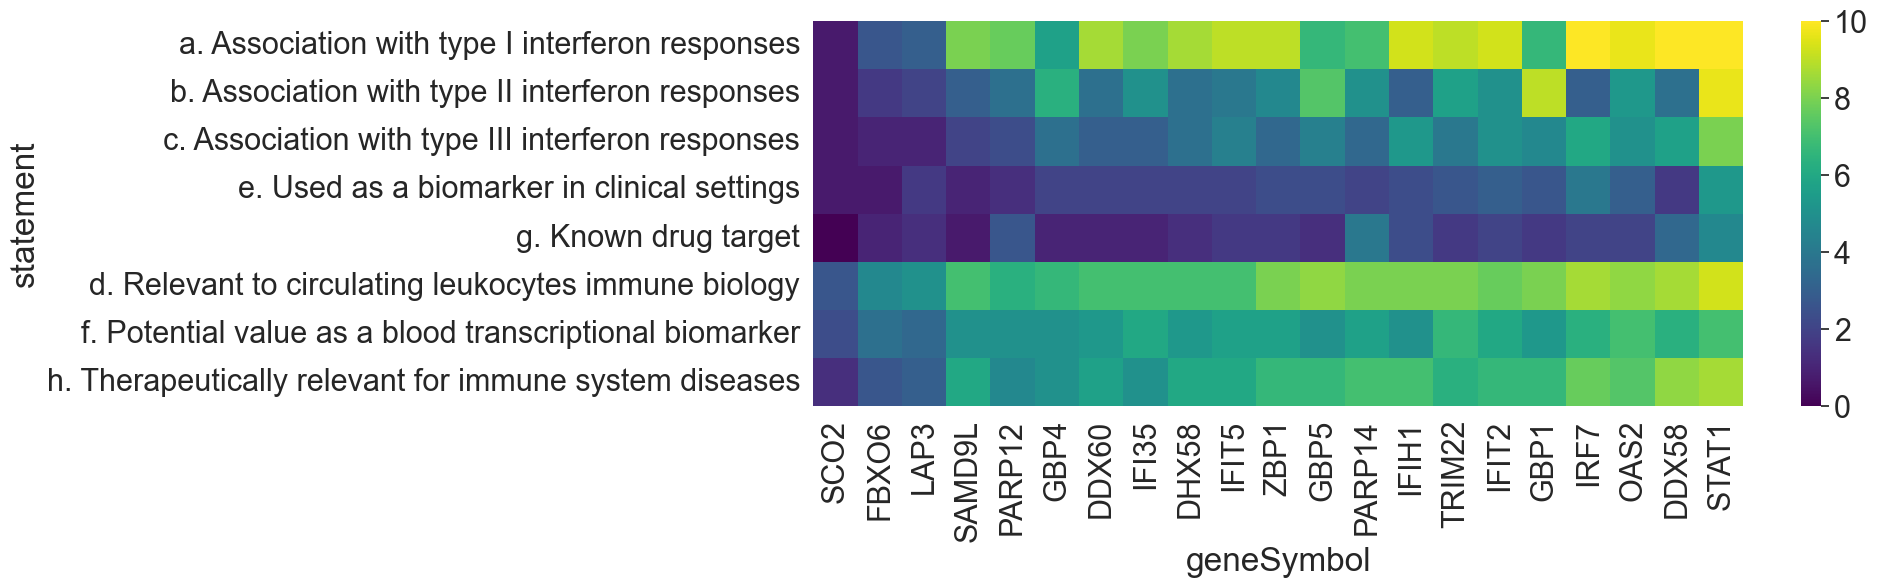

In [240]:
sns.set(font_scale=2)
plt.figure(figsize=(15,5))
sns.heatmap(clusterMap_df.T,cmap="viridis")

In [241]:
get_plot(clusterMap_df, 'M10.1')

NameError: name 'get_plot' is not defined